In [1]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [2]:
! pip install ydata-synthetic

!pip install tensorflow-privacy

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.6 MB/s eta 0:00:00
  Created wheel for easydict: filename=easydict-1.10-py3-none-any.whl size=6491 sha256=38be4d68be7d44dfecc32a84bf98a284f1763a5565c7b2a70e4aa10bc610c2a2
  Stored in directory: /root/.cache/pip/wheels/b7/e3/8c/f814820ac7ef5fd96f38759ce0d3dc51166a3169008b31da53
Successfully built easydict
  Attempting uninstall: easydict
    Found existing installation: easydict 1.13
    Uninstalling easydict-1.13:
      Successfully uninstalled easydict-1.13
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
 

In [3]:
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

2024-06-01 19:17:15.283811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 19:17:15.283931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 19:17:15.409089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [4]:
# Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [5]:
# Specific to TimeGANs
seq_len = 24
n_seq = 6

# hidden_dim = 24
hidden_dim = 256

gamma = 1

dim = 256
batch_size = 128

log_step = 100
learning_rate = 5e-4


### ---------- TUNE FOR DIFFERENT NOISE LEVELS ---------- ###
# noise_dim = 24
noise_dim = 256

### ------------- TUNE FOR DIFFERENT EPOCHS ------------- ###
# epochs=200 # For quick prototyping
epochs = 500
# epochs=50000

### ----------------------------------------------------- ###



gan_args = ModelParameters(
    batch_size=batch_size, lr=learning_rate, noise_dim=noise_dim, layers_dim=dim
)

train_args = TrainParameters(
    epochs=epochs, sequence_length=seq_len, number_sequences=n_seq
)

In [6]:
# DP Params
l2_norm_clip = 1.5
noise_multiplier = 1.3
learning_rate_dp = 0.25

# num_microbatches = 128
# num_microbatches = math.ceil(stock_data.shape[0] / batch_size)



## The data

In [7]:
data_path = '/kaggle/input/stock-data-timegan/stock_data.csv'
stock_data = pd.read_csv(data_path)
cols = list(stock_data.columns)
print(stock_data.shape)

(3685, 6)


## Training the TimeGAN synthetizer

In [8]:
# if path.exists("synthesizer_stock.pkl"):
#     synth = TimeSeriesSynthesizer.load("synthesizer_stock.pkl")
# else:
#     synth = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args)
#     synth.fit(stock_data, train_args, num_cols=cols)
#     synth.save("synthesizer_stock.pkl")



synth = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args)
synth.fit(stock_data, train_args, num_cols=cols)
synth.save("synthesizer_stock.pkl")

A DataProcessor is not available for the TimeGAN.


Emddeding network training:   0%|          | 0/500 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1717269464.728850      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Joint networks training: 100%|██████████| 500/500 [11:27<00:00,  1.38s/it]
/opt/conda/lib/python3.10/site-packages/tensorflow/python/keras/utils/generic_utils.py:486: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### The generated synthetic stock data

In [9]:
stock_data_blocks = processed_stock(path=data_path, seq_len=seq_len)
synth_data = np.asarray(synth.sample(len(stock_data_blocks)))
print(synth_data.shape)

(3661, 24, 6)


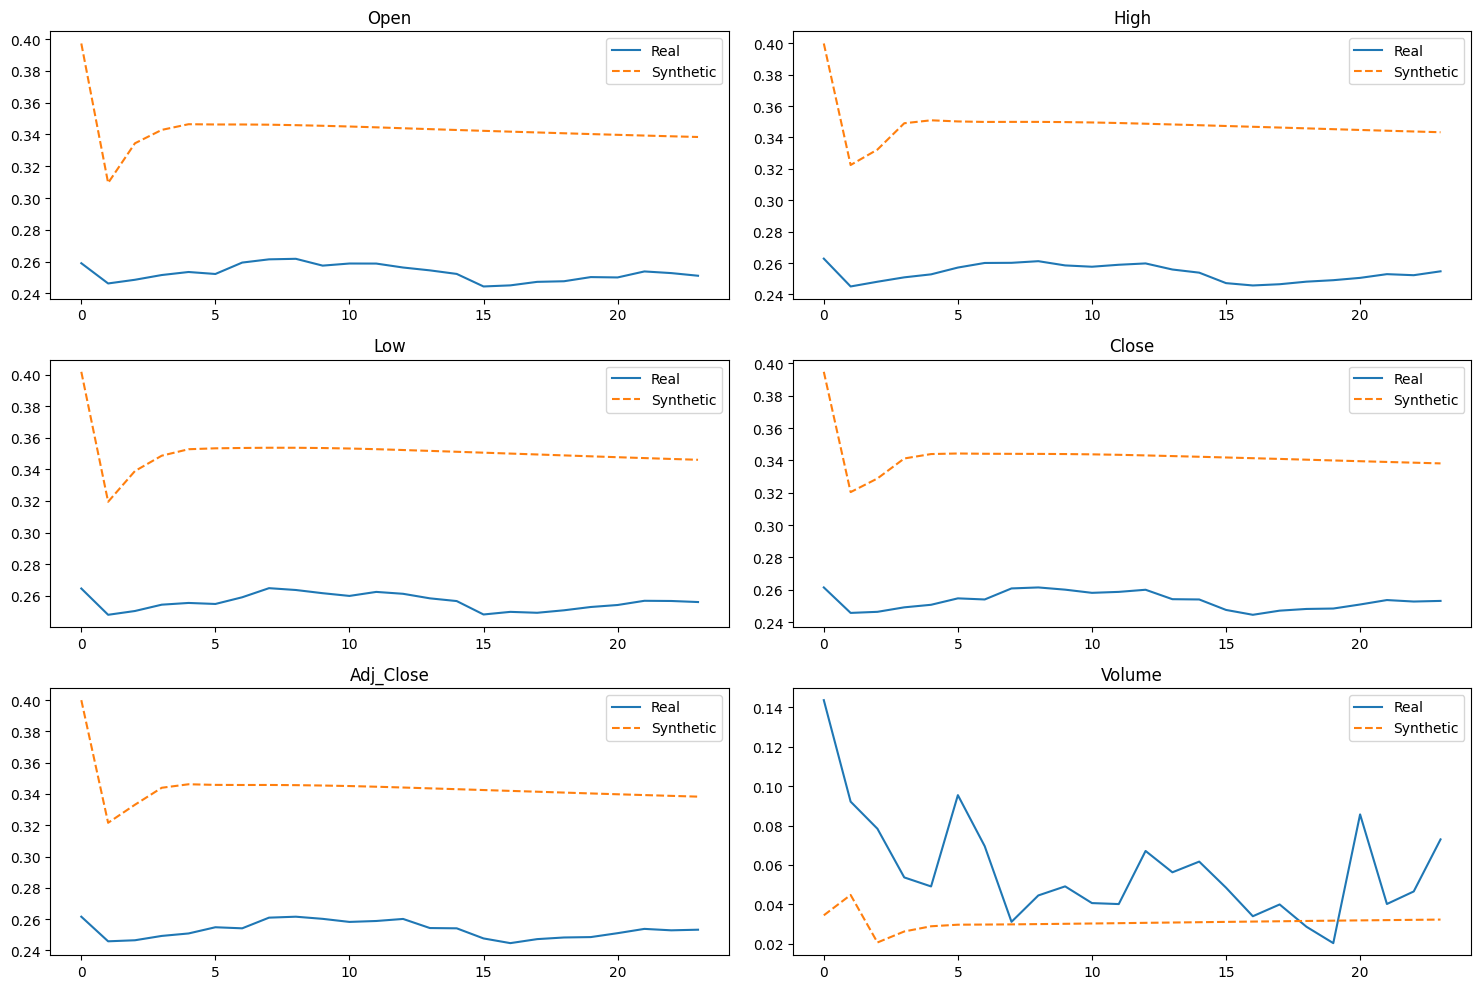

In [10]:

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data_blocks))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data_blocks[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data_blocks))[:sample_size]

real_sample = np.asarray(stock_data_blocks)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
stock_data_reduced = real_sample.reshape(-1, seq_len)
synth_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

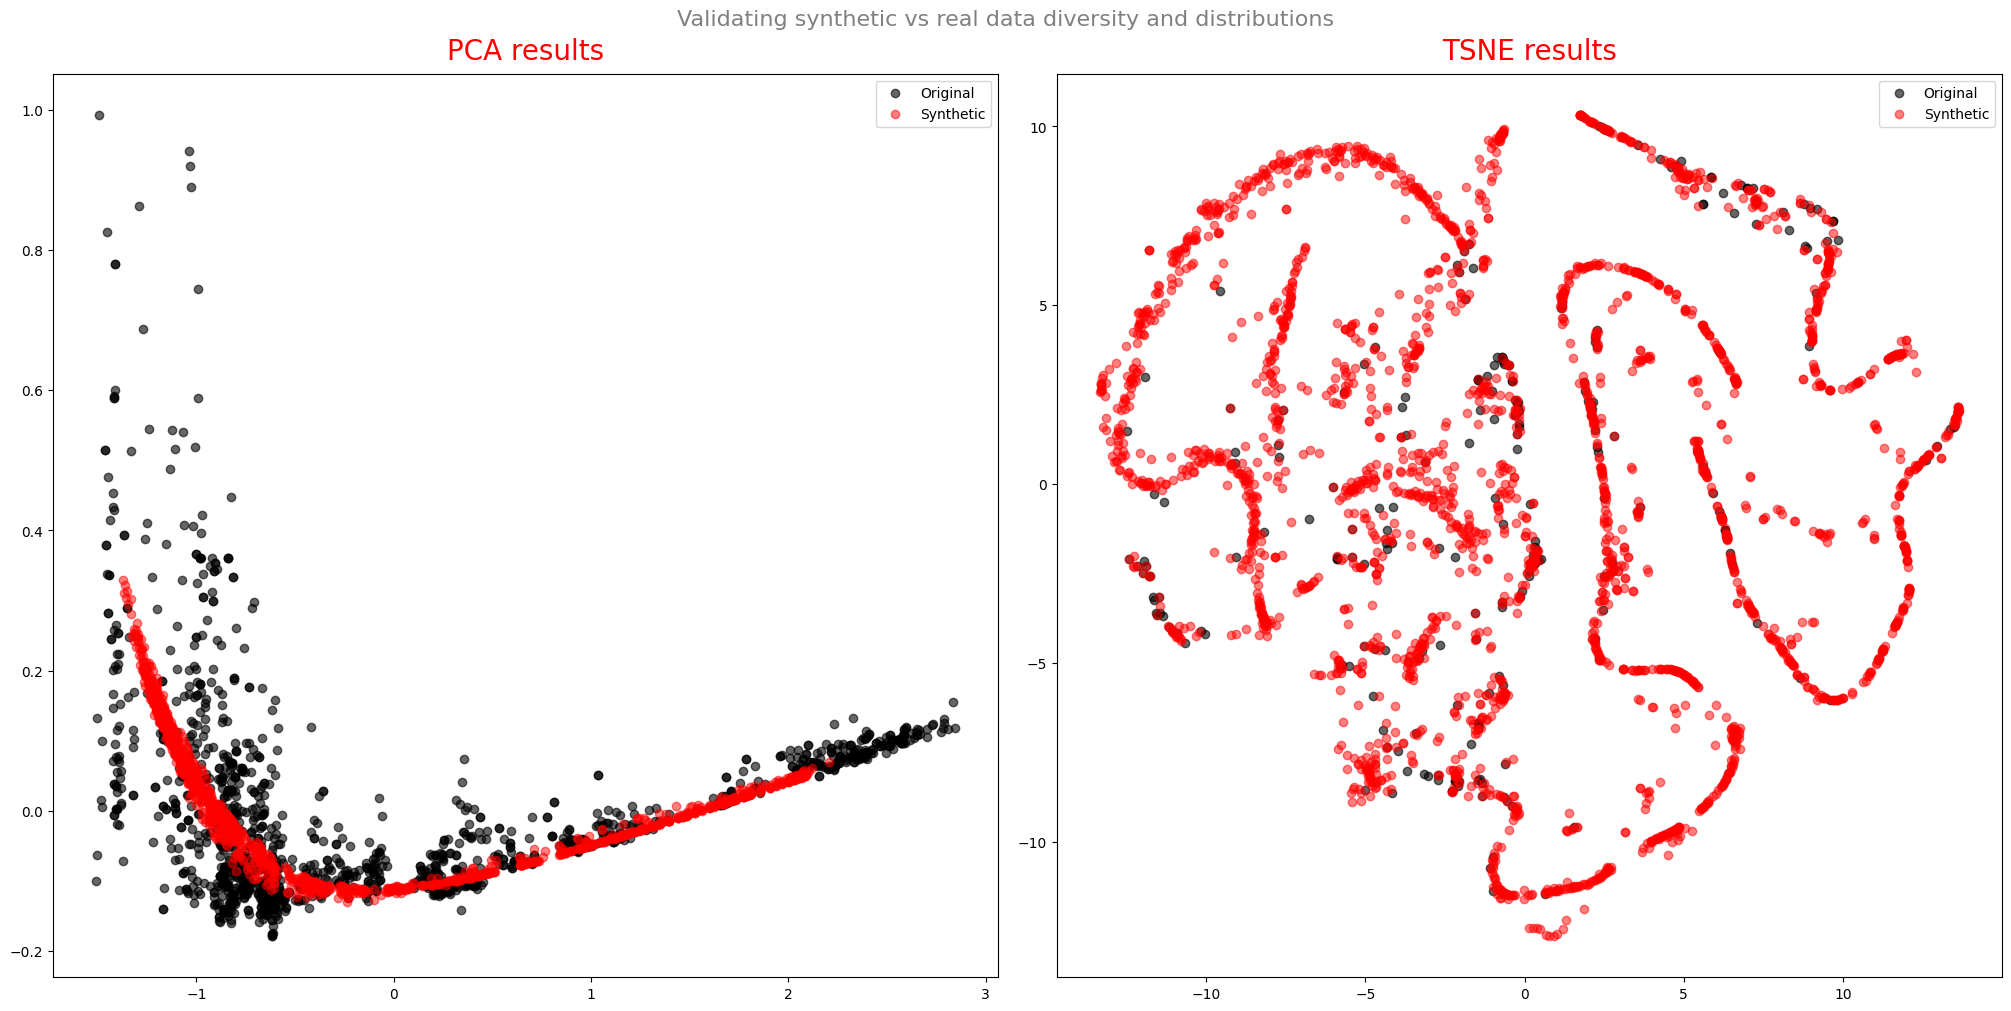

In [12]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.6, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.5, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.6, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.5, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

## INFERENCIAL TESTS

### Train synthetic test real (TSTR)

In [13]:
import tensorflow as tf
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError


In [14]:
#First implement a simple RNN model for prediction
def RNN_regression(units):



  ### ----------------- DP OPTIMIZERS ----------------- ###

  # 1) NAIVE
    # opt = Adam(name='AdamOpt')
    #  loss = MeanAbsoluteError(name='MAE')


  # # 2) DP-SGD
  #   opt = tensorflow_privacy.DPKerasSGDOptimizer(
  #       l2_norm_clip=l2_norm_clip,
  #       noise_multiplier=noise_multiplier,
  #       # num_microbatches=num_microbatches,
  #       learning_rate=learning_rate_dp
  #     )

  #   loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.losses.Reduction.NONE)


  # 3) DP-ADAM

    opt = tensorflow_privacy.DPKerasAdamOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        gradient_accumulation_steps = 3,
        learning_rate=learning_rate_dp
        )

    loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.losses.Reduction.NONE)




  ### ---------------------------------------------------------- ###


    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))


    model.compile(optimizer=opt, loss=loss)



    return model

In [15]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data_blocks)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (2745, 23, 6)
Real X train: (2745, 23, 6)
Synthetic y train: (2745, 6)
Real y train: (2745, 6)
Real X test: (916, 23, 6)
Real y test: (916, 6)


In [16]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200


2024-06-01 19:33:12.294450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] function_optimizer failed: INVALID_ARGUMENT: Node 'Adam/gradients/loop_body/PartitionedCall/pfor/PartitionedCall/gradients/while_grad/while_grad/pfor/PartitionedCall/while/enter/_1487': Connecting to invalid output 28 of source node sequential/RNN_1/PartitionedCall which has 25 outputs.
2024-06-01 19:33:12.404286: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Result #28 of node 'sequential/RNN_1/PartitionedCall' is out of bounds
	when importing GraphDef to MLIR module in GrapplerHook
2024-06-01 19:33:12.478134: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol

22/22 [==============================] - 17s 207ms/step - loss: 0.2129 - val_loss: 0.1632
Epoch 2/200
22/22 [==============================] - 4s 187ms/step - loss: 0.1251 - val_loss: 0.1211
Epoch 3/200
22/22 [==============================] - 4s 199ms/step - loss: 0.1256 - val_loss: 0.1295


In [17]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200


2024-06-01 19:33:42.223812: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Result #28 of node 'sequential_1/RNN_1/PartitionedCall' is out of bounds
	when importing GraphDef to MLIR module in GrapplerHook
2024-06-01 19:33:42.301990: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tfg-cf-sink),tfg-region-to-functional{force-control-capture=true},tfg-lift-legacy-call,symbol-privatize{},symbol-dce,tfg-prepare-attrs-export)} failed: INVALID_ARGUMENT: Result #25 of node 'sequential_1/RNN_1/PartitionedCall' is out of bounds
	when importing GraphDef to MLIR module in GrapplerHook
2024-06-01 19:33:42.303015: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:135] tfg_optimizer{any(tfg-consolidate-attrs,tfg-functional-to-region,tfg.func(tf

22/22 [==============================] - 14s 201ms/step - loss: 0.1800 - val_loss: 0.1244
Epoch 2/200
22/22 [==============================] - 4s 185ms/step - loss: 0.0884 - val_loss: 0.1099
Epoch 3/200
22/22 [==============================] - 4s 186ms/step - loss: 0.1063 - val_loss: 0.1083
Epoch 4/200
22/22 [==============================] - 4s 201ms/step - loss: 0.1088 - val_loss: 0.1321


In [18]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error


real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]
                }

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

29/29 [==============================] - 0s 2ms/step


,r2,MAE,MRLE
Real,0.338076,0.129383,0.015802
Synthetic,0.295075,0.132564,0.016031






---






## **MEASURE THE PRIVACY**

<br>**Delta** ->  Bounds the probability of the privacy guarantee not holding. A rule of thumb is to set it to be less than the inverse of the size of the training dataset.

<br>

**Epsilon** -> This is the **privacy budget**. It measures the strength of the privacy guarantee by bounding how much the probability of a particular model output can vary by including (or excluding) a single training point. **A smaller value for implies a better privacy guarantee.** However, the value is only an upper bound and a large value could still mean good privacy in practice.

In [19]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

In [20]:
inv_train_size = (stock_data.shape[0])**(-1)

In [21]:
epsilon, best_alpha = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=X_synth_train.shape[0],
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs,
    delta=1e-5
)

print(f"\n\nDP-SGD Privacy: epsilon = {epsilon:.2f}, Best Alpha= {best_alpha}, delta = {1e-5} , Inverse Train Data Size = {inv_train_size:.6f}")



DP-SGD Privacy: epsilon = 28.93, Best Alpha= 2.0, delta = 1e-05 , Inverse Train Data Size = 0.000273


In [22]:
# compute_dp_sgd_privacy.compute_dp_sgd_privacy(
#    n=X_synth_train.shape[0],
#     batch_size=batch_size,
#     noise_multiplier=noise_multiplier,
#     epochs=epochs,
#     delta=1e-5
#    )